In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import random
import torch
import pickle
from decimal import Decimal
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import KFold
from modules.function import get_elem_count, alt_read_gfa_dataset, PTR, check_cuda, get_metrics, image, pymatgen_comp, special_formatting, data_generator_gfa
from modules.encoder import Encoder1D, EncoderDNN, Encoder
import re
import torch.optim as optim
from torch.utils.data import DataLoader
import tqdm
import joblib
from modules.representation_schemes import get_vectorized_featues, get_atomic_number_features, get_pettifor_features, get_modified_pettifor_features, get_random_features, get_random_features_dense, random_order

In [3]:
random.seed(0)
torch.manual_seed(0)
cuda = check_cuda()

In [4]:
gfa_dataset_file = 'gfa_dataset.txt'
z_row_column_file = 'Z_row_column.txt'
element_property_file = 'element_property.txt'
common_path = "Files_from_GTDL_paper/{}" 
gfa_dataset = pickle.load(open(common_path.format(gfa_dataset_file), 'rb'))  
RC = pickle.load(open(common_path.format(z_row_column_file), 'rb')) 
new_index=[int(i[4]) for i in RC]#new order 
Z_row_column = pickle.load(open(common_path.format(z_row_column_file), 'rb'))
[property_name_list,property_list,element_name,_]=pickle.load(open(common_path.format(element_property_file), 'rb'))

In [5]:
comps_gfa, y, p = alt_read_gfa_dataset()
count_dict = get_elem_count(comps_gfa)
count_df = pd.DataFrame.from_dict(count_dict, orient='index')
count_df.reset_index(inplace=True)
count_df.rename({'index':'element',0:'count'}, axis=1, inplace=True)
count_df['percent'] = [np.round(count_df.loc[i,'count']/len(comps_gfa)*100,2) for i in range(count_df.shape[0])]

In [6]:
def get_1D_features_gfa(k:str):
    comp_gfa, y, p = alt_read_gfa_dataset()
    y = np.array(y).reshape(-1,1).astype('float32')
    p = np.array(p).reshape(-1,1).astype('float32')
    if k not in ['atomic','pettifor','mod_pettifor','random']:
        print('Unsupported format')
        return None, None, None
    else:
        if k == 'atomic':
            comp, at_order  = get_atomic_number_features(comp_gfa)
        elif k == 'pettifor':
            comp, _  = get_pettifor_features(comp_gfa)
        elif k == 'mod_pettifor':
            comp, _  = get_modified_pettifor_features(comp_gfa)
        elif k == 'random':
            comp,_ = get_random_features(comp_gfa, random_order)
        return comp, y, p

def get_dense_features_gfa():
    comp_gfa, y, p = alt_read_gfa_dataset()
    y = np.array(y).reshape(-1,1).astype('float32')
    p = np.array(p).reshape(-1,1).astype('float32') 
    comp,_ = get_random_features_dense(comp_gfa, random_order)
    return comp, y, p

def get_ptr_features_gfa(gfa_dataset=gfa_dataset):

    gfa_i=[]
    gfa_a=[]
    gfa_b=[]
    gfa_c=[]
    to_discard = ['Rf','Db','Sg','Bh','Hs']
    for i in  gfa_dataset:
        tx_gfa=re.findall('\[[a-c]?\]', i)
        tx1_element=re.findall('[A-Z][a-z]?', i)#[B, Fe, P,No]
        if len(set(tx1_element).intersection(set(to_discard))) == 0:      
            gfa_i.extend(tx_gfa)
            if tx_gfa[0]=='[a]':
                gfa_a.append(gfa_dataset.index(i))
            elif tx_gfa[0]=='[b]':
                gfa_b.append(gfa_dataset.index(i)) 
            else:
                gfa_c.append(gfa_dataset.index(i))
        
    gfa_data_form=[]
    gfa_data_form_p = []
    gfa_data_form_b=[]

#------------------------------------------------------------------------------
#map raw data to 2-D image using PTR
    for i in gfa_a:
        x,p,y = PTR(gfa_dataset[i])
        gfa_data_form=gfa_data_form+x
        gfa_data_form_p = gfa_data_form_p+p
        gfa_data_form_b=gfa_data_form_b+y
    for i in gfa_c:
        x,p,y = PTR(gfa_dataset[i])
        gfa_data_form=gfa_data_form+x
        gfa_data_form_p = gfa_data_form_p+p
        gfa_data_form_b=gfa_data_form_b+y 
    for i in gfa_b:
        x,p,y = PTR(gfa_dataset[i])
        gfa_data_form=gfa_data_form+x
        gfa_data_form_p = gfa_data_form_p+p
        gfa_data_form_b=gfa_data_form_b+y

    X_all = np.array(gfa_data_form).reshape(-1, 1,9, 18).astype('float32') 
    y_all = np.array(gfa_data_form_b).reshape(-1,1).astype('float32')
    p_all = np.array(gfa_data_form_p).reshape(-1,1).astype('float32')
    return X_all, y_all, p_all

# Selecting elements for LOEO

In [6]:
def one_d_elements(lst,count,format:str):
    if format in ['atomic','pettifor','mod_pettifor']:
        if format == 'atomic':
            rep,_ = get_atomic_number_features(lst)
        elif format == 'pettifor':
            rep,_ = get_pettifor_features(lst)
        elif format == 'mod_pettifor':
            rep,_ = get_modified_pettifor_features(lst)
        if len(count.shape) != 2:
            count = count.reshape(-1,1)
        with_count = rep.squeeze()*count
    return with_count

In [7]:
ptr_elements = [image(count_df['element'][i]+str(count_df['percent'][i]), normalized = False) for i in range(count_df.shape[0])]
atomic_elements = one_d_elements(count_df['element'], count_df['percent'].values, format = 'atomic')
pettifor_elements = one_d_elements(count_df['element'], count_df['percent'].values, format = 'pettifor')
mod_pettifor_elements = one_d_elements(count_df['element'], count_df['percent'].values, format = 'mod_pettifor')
norm_dist_ptr= []
norm_dist_atomic = []
norm_dist_pet = []
norm_dist_mod_pet = []
for i in range(len(ptr_elements)):
    norm_dist_ptr.append(np.linalg.norm(ptr_elements[i] - ptr_elements))
    norm_dist_atomic.append(np.linalg.norm(atomic_elements[i] - atomic_elements))
    norm_dist_pet.append(np.linalg.norm(pettifor_elements[i] - pettifor_elements))
    norm_dist_mod_pet.append(np.linalg.norm(mod_pettifor_elements[i] - mod_pettifor_elements))
norm_dist_pet = np.array(norm_dist_pet)
norm_dist_atomic = np.array(norm_dist_atomic)
norm_dist_ptr = np.array(norm_dist_ptr)
norm_dist_mod_pet = np.array(norm_dist_mod_pet)

In [8]:
count_df['percent'] = [np.round(count_df.loc[i,'count']/len(comps_gfa)*100,2) for i in range(count_df.shape[0])]
elements = ['Al','Ni','Fe','Cr','Co','Ti','Mo','Nb','V','W']
count_df[[el in elements for el in count_df['element'].values]].sort_values('percent')

,element,count,percent
37,W,380,1.82
9,V,500,2.40
21,Nb,1078,5.17
22,Mo,1222,5.86
8,Ti,1930,9.25
13,Co,2294,10.99
10,Cr,2714,13.00
12,Fe,5302,25.40
14,Ni,6112,29.29
4,Al,7084,33.94


In [18]:
bins = np.arange(min(count_df['percent']),max(count_df['percent']),8)
np.digitize(count_df['percent'],bins)

array([1, 1, 1, 2, 5, 1, 1, 1, 2, 1, 2, 2, 4, 2, 4, 3, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

# Statistical significance

In [7]:
methods = ['dense','atomic','pettifor','mod_pettifor','random','PTR']
predicted_dict = {}
for method in methods:
    if method != 'PTR':
        model = torch.jit.load('saved_models/best_models/1DEncoder_{}.pt'.format(method))
        if method!='dense':
            X,y,p = get_1D_features_gfa(method) 
            
        else:
            X,y,p = get_dense_features_gfa() 
    else:
        model = torch.jit.load('saved_models/best_models/2DEncoder_{}.pt'.format(method))
        X,y,p = get_ptr_features_gfa()
    if X.dtype != torch.float32:
            X = torch.from_numpy(X)
    if p.dtype != torch.float32:
            p = torch.from_numpy(p)
    if cuda:
            model = model.cuda()
            X = X.cuda()
            p = p.cuda()
    with torch.no_grad():
        y_pred = model(X,p).to('cpu').detach().numpy()
    predicted_dict[method] = y_pred

In [8]:
from statsmodels.stats.contingency_tables import mcnemar
from itertools import combinations

methods = ['dense','atomic','random','pettifor','mod_pettifor','PTR']
bin_dict = {}
for k in predicted_dict.keys():
    yes =[]
    for i,ph in enumerate(predicted_dict[k]):
        if predicted_dict[k][i] == y[i]:
            yes.append(1)
        else:
            yes.append(0)
    bin_dict[k] = np.array(yes)
compare_keys = list(combinations(methods,2))
zero = np.ones((len(methods),len(methods)))
for key in compare_keys:
    
    contengency = np.zeros((2,2))
    a,b = key
    cl_ptr = bin_dict[a]
    cl_com = bin_dict[b]
    ind1 = np.argwhere(np.array(methods)==a)
    ind2 = np.argwhere(np.array(methods)==b)
    for i in range(len(cl_ptr)):
        if cl_ptr[i] == cl_com[i]== 1:
            contengency[0,0] +=1
        elif (cl_ptr[i] == 1)*(cl_com[i] == 0):
            contengency[0,1] += 1
        elif (cl_ptr[i] == 0)*(cl_com[i] == 1):
            contengency[1,0] += 1
        elif cl_ptr[i] == cl_com[i]== 0:
            contengency[1,1] += 1
    result = mcnemar(contengency, exact=True)
    alpha = 0.05
    zero[ind1,ind2] = result.pvalue
    if result.pvalue > alpha:
        
        print('Same proportions of errors (fail to reject H0) for PTR and {}'.format(key))
    else:
        print('Different proportions of errors (reject H0) for PTR and {}'.format(key))

Different proportions of errors (reject H0) for PTR and ('dense', 'atomic')
Different proportions of errors (reject H0) for PTR and ('dense', 'random')
Different proportions of errors (reject H0) for PTR and ('dense', 'pettifor')
Different proportions of errors (reject H0) for PTR and ('dense', 'mod_pettifor')
Different proportions of errors (reject H0) for PTR and ('dense', 'PTR')
Different proportions of errors (reject H0) for PTR and ('atomic', 'random')
Different proportions of errors (reject H0) for PTR and ('atomic', 'pettifor')
Different proportions of errors (reject H0) for PTR and ('atomic', 'mod_pettifor')
Different proportions of errors (reject H0) for PTR and ('atomic', 'PTR')
Same proportions of errors (fail to reject H0) for PTR and ('random', 'pettifor')
Different proportions of errors (reject H0) for PTR and ('random', 'mod_pettifor')
Different proportions of errors (reject H0) for PTR and ('random', 'PTR')
Different proportions of errors (reject H0) for PTR and ('petti

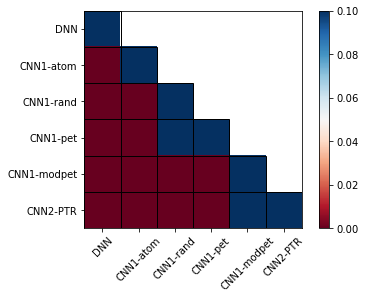

In [9]:
from matplotlib import cm as cm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
methods = ['dense','atomic','random','pettifor','mod_pettifor','PTR']
names = ['DNN','CNN1-atom','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']
mask =  np.tri(zero.T.shape[0], k=-1)
mask =  np.tri(zero.T.shape[0], k=-1)
A = np.ma.array(zero, mask=mask).T
truth = np.where(mask == 1)

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xticks(np.arange(0, len(methods), 1))
ax1.set_yticks(np.arange(0, len(methods), 1))
# use dir(matplotlib.cm) to get a list of the installed colormaps
# the "_r" means "reversed" and accounts for why zero values are plotted as white
cmap = cm.get_cmap('RdBu')

#norm = MidPointNorm(midpoint=)
#cmap.set_bad('w')
plt.imshow(A, cmap = cmap, vmin = 0, vmax = 0.1)
for i in range(len(truth[0])):
    highlight_cell(truth[1][i],truth[0][i])
diag = [0,1,2,3,4,5]
for k in diag:
    highlight_cell(k,k)
ax1.set_xticklabels(names, rotation = 45)
ax1.set_yticklabels(names)
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
plt.colorbar()

In [14]:
results_dict_loc = 'results/results.json'
if os.path.exists(results_dict_loc):
    with open(results_dict_loc,'r') as fid:
        sup_results_dict = json.load(fid)
    temp_dict = {}
    temp_dict['mcnemar_gfa'] = {'names' : names, 'p_vals' : zero.tolist()}
    sup_results_dict = sup_results_dict|temp_dict
    with open(results_dict_loc,'w') as fid:
        json.dump(sup_results_dict,fid)
else:
    sup_results_dict = {}
    sup_results_dict['mcnemar_gfa'] = {'names' : names, 'p_vals' : zero.tolist()}
    with open(results_dict_loc,'w') as fid:
        json.dump(sup_results_dict,fid)


# Running the models

In [105]:
elements = ['Al','Ni','Fe','Cr','Co','Ti','Mo','Nb','V','W']
filename = 'misc/gfa_gen_splits.json'
if os.path.exists(filename):
    with open(filename,'rb') as fid:
        gfa_gen_dict = json.load(fid)
        print('Split file loaded')
else:

    gfa_gen_dict = {}
    for el in elements:
        train_inds, test_inds,all_cv_train, all_cv_test = [],[],[],[]
        for i,c in enumerate(comps_gfa):
            if el in c.get_el_amt_dict().keys():
                train_inds.append(i)
            else:
                test_inds.append(i)
        X_train = np.array(comps_gfa)[train_inds]
        kf = KFold(n_splits=5)
        for tr, ts in kf.split(X_train):
            all_cv_train.append(tr.tolist())
            all_cv_test.append(ts.tolist())
        gfa_gen_dict[el] = {'train':train_inds,'test':test_inds, 'cv_train':all_cv_train, 'cv_test':all_cv_test}
    
    with open(filename,'w') as fid:
        json.dump(gfa_gen_dict, fid)
        print('Split file written!')
        

/tmp/ipykernel_260629/291367725.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.array(comps_gfa)[train_inds]


Split file written!


In [111]:
saveloc = 'saved_models/LOEO_Encoders'
if not os.path.exists(saveloc):
    os.makedirs(f'{saveloc}')

In [119]:
result_file = 'results/gfa_LOEO_stats.json'
methods = ['dense','atomic','pettifor','mod_pettifor','random','PTR']
batch = 64
num_iterations = 2000
log_interval = int(5e2)
results_dict = {}
for method in methods:
    results_dict[method] = {}
    if method == 'dense':
        X, y , p = get_dense_features_gfa()    
    elif method in ['atomic','pettifor','mod_pettifor','random']:
        X,y,p = get_1D_features_gfa(method)     
    elif method == 'PTR':
        X,y,p = get_ptr_features_gfa()
    for k in gfa_gen_dict.keys():
        results_dict[method][k] = {}
        f1_max = 0
        best_fold_model = 0
        LOEO_dict = {'Fold_stats':{}}
        test_inds = gfa_gen_dict[k]['test']
        X_test = X[test_inds]
        y_test = y[test_inds]
        p_test = p[test_inds]
        if X_test.dtype != torch.float32:
            X_test = torch.from_numpy(X_test)
        if p_test.dtype != torch.float32:
            p_test = torch.from_numpy(p_test)
        if cuda:
            X_test = X_test.cuda()
            p_test = p_test.cuda()
        cv_train_inds, cv_test_inds = gfa_gen_dict[k]['cv_train'],gfa_gen_dict[k]['cv_test']
        for i in range(len(cv_train_inds)):
            fold_train_inds, fold_test_inds = cv_train_inds[i], cv_test_inds[i]
            X_train_fold,y_train_fold ,p_train_fold  = X[fold_train_inds], y[fold_train_inds], p[fold_train_inds]
            X_test_fold, y_test_fold, p_test_fold = X[fold_test_inds], y[fold_test_inds], p[fold_test_inds]
            Xy = [(X_train_fold[i],y_train_fold[i],p_train_fold[i]) for i in range(len(y_train_fold))]
            train_loader = DataLoader(Xy, batch_size = batch , shuffle=True)
            if X_test_fold.dtype != torch.float32:
                X_test_fold = torch.from_numpy(X_test_fold)
            if p_test_fold.dtype != torch.float32:
                p_test_fold = torch.from_numpy(p_test_fold)
            if method == 'dense':
                encoder = EncoderDNN(X_train_fold.shape[-1],3,42,1)
            elif method in ['atomic','pettifor','mod_pettifor','random']:
                encoder = Encoder1D(1,1)
            elif method == 'PTR':
                encoder = Encoder(1,1)
            
            if cuda:
                encoder = encoder.cuda()
                X_test_fold, p_test_fold = X_test_fold.cuda(), p_test_fold.cuda()
            e_optimizer = optim.Adam(encoder.parameters(),lr = 2e-4)
            for iter in tqdm.notebook.tqdm(range(num_iterations)):
                train_loss = 0.0
                for data in train_loader:
                    X_t,y_t,p_t = data
                    if cuda:
                        X_t = X_t.cuda()
                        y_t = y_t.cuda()
                        p_t = p_t.cuda()
                    e_optimizer.zero_grad()
                    target = encoder(X_t,p_t)
                    if cuda:
                        target = target.cuda()
                    e_error = torch.nn.BCELoss()(target,y_t)
                    e_error.backward(retain_graph=True)
                    e_optimizer.step()
                    train_loss += e_error.cpu().item()
                if iter == 0 or (iter + 1) % log_interval == 0:  
                    print('{} : Element {}, Fold {}, Epoch : {}, Loss : {}'.format(method,k,i,iter+1,train_loss))
            spec_saveloc = os.path.join(saveloc,method)
            if not os.path.exists(spec_saveloc):
                os.makedirs(f'{spec_saveloc}')
            joblib.dump(encoder,os.path.join(spec_saveloc,'LOEOEncoder_{}_fold{}.pt'.format(k,i)))
            y_predict_fold = (encoder(X_test_fold,p_test_fold)).to('cpu').detach().numpy()
            metrics_fold = get_metrics(y_test_fold,np.round(y_predict_fold))
            LOEO_dict['Fold_stats'][i] = metrics_fold
            y_predict = (encoder(X_test,p_test)).to('cpu').detach().numpy()
            metrics = get_metrics(y_test,np.round(y_predict))
            f1_predict = metrics[3]
            if f1_predict>f1_max:
                f1_max = f1_predict
                best_fold_model = i
                LOEO_dict['Best_f1'] = f1_max
                LOEO_dict['Best_fold'] = best_fold_model
        results_dict[method][k] = LOEO_dict
        if os.path.exists(result_file):
            with open(result_file,'rb') as fid:
                data_file = json.load(fid)
            updated_file = data_file|results_dict
            with open(result_file,'w') as f:
                json.dump(updated_file,f)
        else:
            with open(result_file, 'w') as f:
                json.dump(results_dict, f)
        

  0%|          | 0/2000 [00:00<?, ?it/s]

dense : Element Al, Fold 0, Epoch : 1, Loss : 59.46879905462265
dense : Element Al, Fold 0, Epoch : 500, Loss : 5.203987020999193
dense : Element Al, Fold 0, Epoch : 1000, Loss : 4.191072904504836
dense : Element Al, Fold 0, Epoch : 1500, Loss : 3.908863263204694
dense : Element Al, Fold 0, Epoch : 2000, Loss : 3.772492978256196


  0%|          | 0/2000 [00:00<?, ?it/s]

dense : Element Al, Fold 1, Epoch : 1, Loss : 60.659728050231934
dense : Element Al, Fold 1, Epoch : 500, Loss : 4.441414857748896
dense : Element Al, Fold 1, Epoch : 1000, Loss : 3.7315723549108952
dense : Element Al, Fold 1, Epoch : 1500, Loss : 3.4324506116099656
dense : Element Al, Fold 1, Epoch : 2000, Loss : 3.312455483013764


  0%|          | 0/2000 [00:00<?, ?it/s]

dense : Element Al, Fold 2, Epoch : 1, Loss : 57.727927446365356
dense : Element Al, Fold 2, Epoch : 500, Loss : 4.739594083279371
dense : Element Al, Fold 2, Epoch : 1000, Loss : 3.9628490114118904
dense : Element Al, Fold 2, Epoch : 1500, Loss : 4.0655128138605505
dense : Element Al, Fold 2, Epoch : 2000, Loss : 3.1386625161394477


  0%|          | 0/2000 [00:00<?, ?it/s]

dense : Element Al, Fold 3, Epoch : 1, Loss : 51.827803552150726
dense : Element Al, Fold 3, Epoch : 500, Loss : 5.852062711492181
dense : Element Al, Fold 3, Epoch : 1000, Loss : 4.74813527520746
dense : Element Al, Fold 3, Epoch : 1500, Loss : 4.108698435593396
